Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.
Epoch 1/10


1256/1256 [==============================] - 640s 477ms/step - loss: 0.1028 - accuracy: 0.9662 - val_loss: 0.0260 - val_accuracy: 0.9898
Epoch 2/10
1256/1256 [==============================] - 598s 476ms/step - loss: 0.0465 - accuracy: 0.9839 - val_loss: 0.0187 - val_accuracy: 0.9935
Epoch 3/10
1256/1256 [==============================] - 581s 463ms/step - loss: 0.0416 - accuracy: 0.9861 - val_loss: 0.0154 - val_accuracy: 0.9954
Epoch 4/10
1256/1256 [==============================] - 593s 472ms/step - loss: 0.0325 - accuracy: 0.9885 - val_loss: 0.0108 - val_accuracy: 0.9963
Epoch 5/10
1256/1256 [==============================] - 558s 444ms/step - loss: 0.0303 - accuracy: 0.9900 - val_loss: 0.0238 - val_accuracy: 0.9921
Epoch 6/10
1256/1256 [==============================] - 609s 485ms/step - loss: 0.0337 - accuracy: 0.9877 - val_loss: 0.0061 - val_

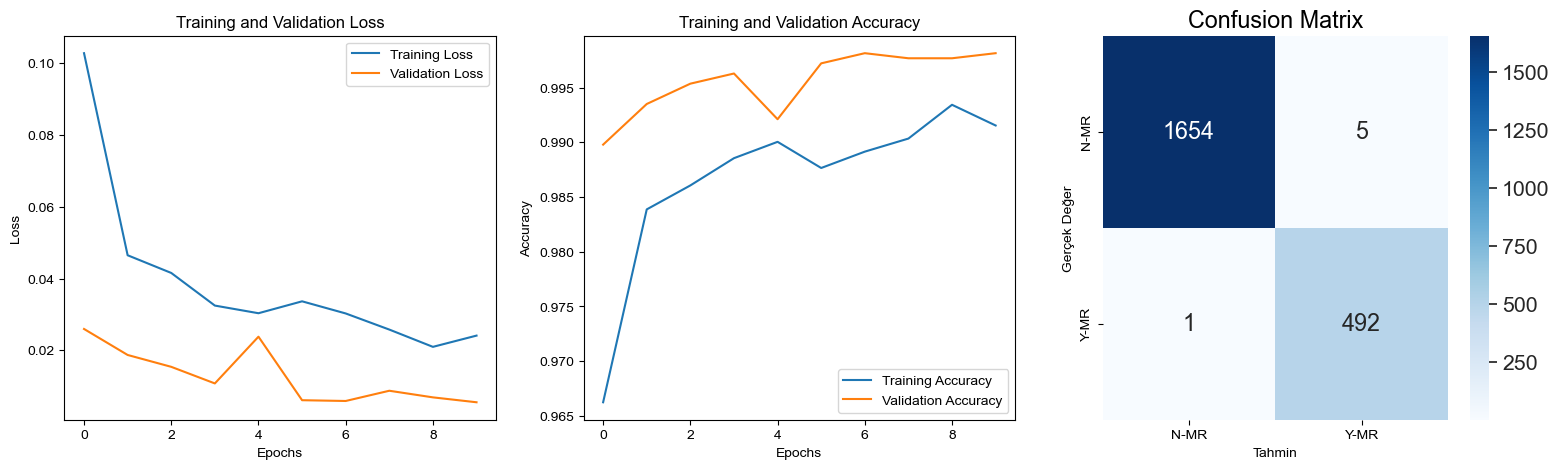


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1659
           1       0.99      1.00      0.99       493

    accuracy                           1.00      2152
   macro avg       0.99      1.00      1.00      2152
weighted avg       1.00      1.00      1.00      2152



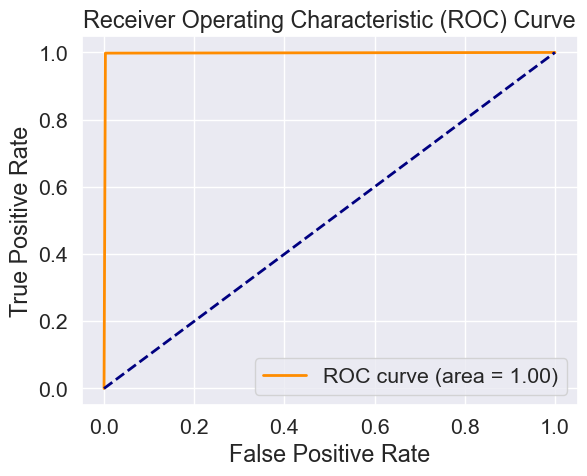

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Early stopping callback'i oluşturma
early_stopping = EarlyStopping(
    monitor='val_loss',  # Takip edilecek metrik (örneğin, doğrulama kaybı)
    patience=3,  # Metrik iyileşmediğinde veya durduğunda beklenen epoch sayısı
    restore_best_weights=True  # En iyi ağırlıkları geri yükleme
)

# ModelCheckpoint callback'i oluşturma
densenet_checkpoint = ModelCheckpoint(
    'DenseNet121_model.keras',  # Modelin kaydedileceği dosya adı
    monitor='val_loss',
    save_best_only=True,  # Sadece en iyi modeli kaydet
    mode='min'  # 'min' olarak ayarlanmalı, çünkü kayıpı minimize etmek istiyoruz
)

# Define image dataset
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)

# DenseNet121 modelini yükleme
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))

# Yeni model oluşturma
model = Sequential([
    densenet_model,  # DenseNet121 modelini ekliyoruz
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.num_classes, activation='softmax')
])

# Katmanları dondurma
for layer in densenet_model.layers:
    layer.trainable = False

# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model eğitimi
history = model.fit(train_dataset, epochs=10, validation_data=validation, callbacks=[early_stopping, densenet_checkpoint])

# Eğitim ve doğrulama kaybı ve doğruluğu görselleştirme
plt.figure(figsize=(16, 5))

# Eğitim ve doğrulama kaybı
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Confusion Matrix
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true = test_dataset.labels
conf_matrix = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştirme
plt.subplot(1, 3, 3)
sns.set(font_scale=1.4)  # Font ölçeğini ayarla
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['N-MR', 'Y-MR'],
            yticklabels=['N-MR', 'Y-MR'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek Değer')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)

# ROC Eğrisi ve AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()


In [2]:
# Define image dataset
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)


Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model


densenet_model=load_model("DenseNet121_model.keras")
resnet50_model=load_model("ResNet50.keras")
inceptionV3_model=load_model("inceptionv3.keras")
vgg16_model=load_model("VGG16_model.keras")
cnn_model=load_model("CNN_model.keras")



dense_predictions=densenet_model.predict(test_dataset)
resnet50_predictions=densenet_model.predict(test_dataset)
inceptionV3_predictions=densenet_model.predict(test_dataset)
vgg16_predictions=densenet_model.predict(test_dataset)
cnn_predictions=densenet_model.predict(test_dataset)


dense_true_classes=test_dataset.classes
resnet50_true_classes=test_dataset.classes
inceptionV3_true_classes=test_dataset.classes
vgg16_true_classes=test_dataset.classes
cnn_true_classes=test_dataset.classes




68/68 [==============================] - 44s 650ms/step


In [27]:
categories={0:'N-MR', 1:'Y-MR'}
dense_predicted_classes = np.argmax(dense_predictions, axis=1)

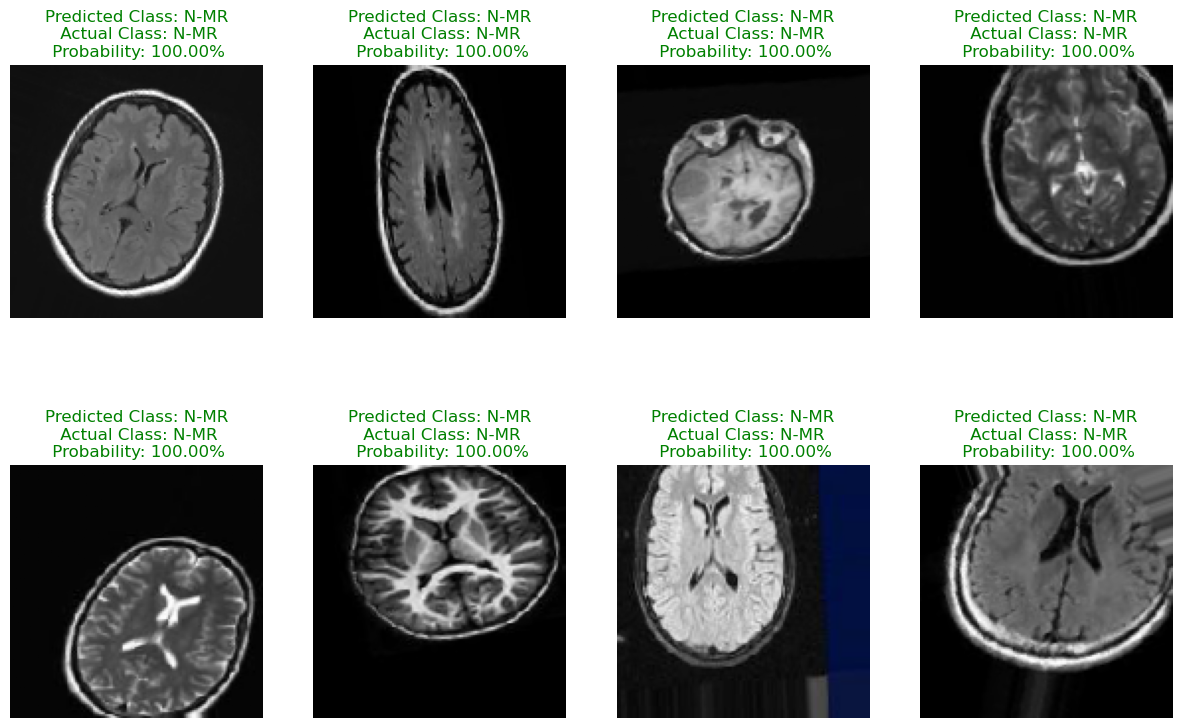

In [30]:
predicted_classes = np.argmax(dense_predictions, axis=1)  # En yüksek olasılığa sahip sınıfları al
prediction_probabilities = np.max(dense_predictions, axis=1)  # En yüksek olasılıkları al
batch_1_img = train_dataset[0]
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(5,4,i+1)
    plt.imshow(batch_1_img[0][i])
    predicted_class_label=categories[dense_predicted_classes[i]]
    actual_class_label=categories[dense_true_classes[i]]

    if dense_predicted_classes[i] == dense_true_classes[i]:
        title_color='green'
    else:
        title_color='red'

    prediction_probability = prediction_probabilities[i] * 100

    title = f'Predicted Class: {predicted_class_label}\n Actual Class: {actual_class_label}\n Probability: {prediction_probability:.2f}%'
    plt.title(title,color=title_color)
    plt.axis('off')
plt.subplots_adjust(top=1.4)
plt.show()


In [26]:
test_dataset.class_indices

{'N-MR': 0, 'Y-MR': 1}

In [38]:
model_names = [
    "DenseNet121_model.keras",
    "ResNet50.keras",
    "inceptionv3.keras",
    "VGG16_model.keras",
    "CNN_model.keras"
]

# Model tahminlerini saklamak için bir liste
all_model_preds = []
all_labels = [dense_true_classes,resnet50_true_classes,inceptionV3_true_classes,vgg16_true_classes,cnn_true_classes]
all_labels = np.concatenate(all_labels)


# Her bir modelin tahminlerini elde etme
for model_name in model_names:
    # Modeli yükle
    model = load_model(model_name)

    # Test verisi için tahminleri elde et
    model_preds = model.predict(test_dataset)

    # Her bir modelin tahminlerini listeye ekle
    all_model_preds.append((model_name, model_preds))


# ROC eğrilerini tek bir grafikte gösterme
plt.figure(figsize=(10, 8))
for model_name, model_preds, all_label in zip(model_names, all_model_preds, all_labels):
    fpr, tpr, _ = roc_curve(all_label, model_preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


68/68 [==============================] - 6s 86ms/step


InvalidParameterError: The 'y_true' parameter of roc_curve must be an array-like. Got 0 instead.

<Figure size 1000x800 with 0 Axes>

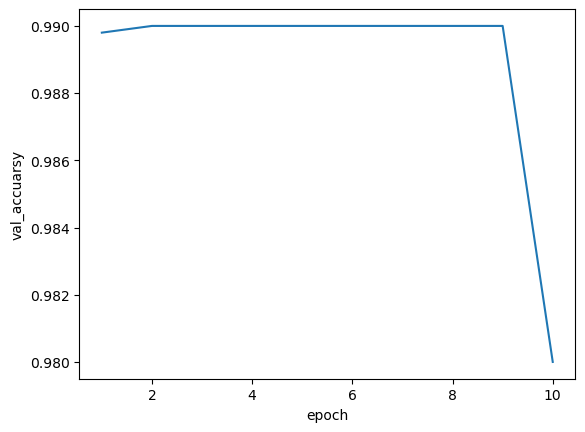

In [40]:
epoch=[1,2,3,4,5,6,7,8,9,10]
dense_accuarsy=[0.9898, 0.99, 0.99, 0.99, 0.99,0.99,0.99,0.99,0.99,0.98]
resnet_accuarsy=[0.8709, 0.99, 0.99, 0.99, 0.99,0.99,0.99,0.99,0.99,0.98]
val_accuarsy=[0.9898, 0.99, 0.99, 0.99, 0.99,0.99,0.99,0.99,0.99,0.98]
val_accuarsy=[0.9898, 0.99, 0.99, 0.99, 0.99,0.99,0.99,0.99,0.99,0.98]
val_accuarsy=[0.9898, 0.99, 0.99, 0.99, 0.99,0.99,0.99,0.99,0.99,0.98]

plt.plot(epoch,dense_accuarsy)  
plt.plot(epoch,resnet_accuarsy)      
plt.plot(epoch,val_accuarsy)      
plt.plot(epoch,val_accuarsy)      
plt.plot(epoch,val_accuarsy)      

plt.xlabel("epoch")
plt.ylabel("val_accuarsy")
plt.show()
